In [1]:
print('hello')


hello


In [27]:
import os
file_name = r"C:\Users\98937\NOBY\carbon_bombs_kuhne_2022.xlsx"
print(os.path.exists(file_name))

True


In [28]:
import xarray as xr
import pickle 
import matplotlib as plt
import os
import cartopy as cp
import geopandas as gp
import sys 
import numpy as np
import pandas as pd
import scipy as sp
import regionmask as rg
import textwrap as tp
#3a
def pre_processing_carbon_bombs(excel_file):
    df = pd.read_excel(excel_file, sheet_name='Full Carbon Bombs List')
    return df 

file_name = r"C:\Users\98937\NOBY\carbon_bombs_kuhne_2022.xlsx"

print(os.path.exists(file_name))  # should be True

df = pre_processing_carbon_bombs(file_name)

print(df.head())


True
   New                    Name    Country  Potential emissions (Gt CO2)  \
0    *         Tannezuft Shale    Algeria                      2.347867   
1  NaN  Hassi R'Mel (Domestic)    Algeria                      2.271542   
2  NaN          Hassi Messaoud    Algeria                      1.215923   
3  NaN       Vaca Muerta Shale  Argentina                      5.177782   
4  NaN   Red Hill Coal Project  Australia                      4.564469   

      Fuel  Unnamed: 5  Country.1  # of Carbon Bombs  Potential Emissions  \
0  Oil&Gas         NaN        NaN                NaN                  NaN   
1  Oil&Gas         NaN        NaN                NaN                  NaN   
2  Oil&Gas         NaN    Algeria                3.0             5.835333   
3  Oil&Gas         NaN  Argentina                1.0             5.177782   
4     Coal         NaN        NaN                NaN                  NaN   

   Rank           Country.2  # of Carbon Bombs.1  Potential Emissions.1  \
0   1.

In [29]:
#3b keping only the column that we need 
df = df[["New", "Name", "Country", "Potential emissions (Gt CO2)", "Fuel"]] 
print(df)

                        New                    Name    Country  \
0                         *         Tannezuft Shale    Algeria   
1                       NaN  Hassi R'Mel (Domestic)    Algeria   
2                       NaN          Hassi Messaoud    Algeria   
3                       NaN       Vaca Muerta Shale  Argentina   
4                       NaN   Red Hill Coal Project  Australia   
..                      ...                     ...        ...   
424                     NaN         Sengwe Colliery   Zimbabwe   
425                   Total                     NaN        NaN   
426           Total Oil&Gas                     NaN        NaN   
427              Total Coal                     NaN        NaN   
428  Total New Carbon Bombs                     NaN        NaN   

     Potential emissions (Gt CO2)     Fuel  
0                        2.347867  Oil&Gas  
1                        2.271542  Oil&Gas  
2                        1.215923  Oil&Gas  
3                        5.

In [30]:
#3c converting potential column to float
df = df.copy()
df["Potential emissions (Gt CO2)"] = pd.to_numeric(df["Potential emissions (Gt CO2)"], errors='coerce')



In [31]:
#3d create new column
 #i used chatgpt for this part first i try to write it witout lambda it gets complicated and i got some errors i search for that and found this beutiful function:)

df["new"] = df["New"].apply(lambda x: 1 if str(x).strip() == "*" else 0)

In [32]:
#3e name as an index so we can refer to rows by their name
df = df.set_index("Name")

In [33]:
#3f convert df to a certain dataset(ds)
#xarray ba ye moteghayer va dade on moteghayer tarif mishe ma ghblan name ro index kardim yani mitonim alan as name va tabe harkodom azon moteghayera estefade konim bara list kardan moteghayer vali in name feghat bara adress dadan va peyda kardan adad estefade mishe 
ds = xr.Dataset(
    data_vars=dict(
        potential_emissions=(["name"], df["Potential emissions (Gt CO2)"].values),
        new=(["name"], df["new"].values),
        total=(["name"], df["Potential emissions (Gt CO2)"].values),
        total_oil_and_gas=(["name"], df.apply(
            lambda r: r["Potential emissions (Gt CO2)"] if r["Fuel"] in ["Oil", "Gas"] else 0,
            axis=1)),
        total_coal=(["name"], df.apply(
            lambda r: r["Potential emissions (Gt CO2)"] if r["Fuel"] == "Coal" else 0,
            axis=1)),
        total_new_carbon_bombs=(["name"], df.apply(
            lambda r: r["Potential emissions (Gt CO2)"] if r["new"] == 1 else 0,
            axis=1)),
    ), ##now for identifing wich parameter belong to where :
    coords=dict(
    name=df.index.values,
    country=(["name"], df["Country"].values),
    fuel=(["name"], df["Fuel"].values)
     ),
    attrs=dict(
    description="Processed carbon bomb dataset from Kühne et al. (2022)",
    units="GtCO2"
    )
) 
print(ds)


<xarray.Dataset> Size: 31kB
Dimensions:                 (name: 429)
Coordinates:
  * name                    (name) object 3kB 'Tannezuft Shale' ... nan
    country                 (name) object 3kB 'Algeria' 'Algeria' ... nan nan
    fuel                    (name) object 3kB 'Oil&Gas' 'Oil&Gas' ... 230 169
Data variables:
    potential_emissions     (name) float64 3kB 2.348 2.272 1.216 ... 536.2 419.0
    new                     (name) int64 3kB 1 0 0 0 0 1 0 0 ... 1 0 1 0 0 0 0 0
    total                   (name) float64 3kB 2.348 2.272 1.216 ... 536.2 419.0
    total_oil_and_gas       (name) int64 3kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    total_coal              (name) float64 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    total_new_carbon_bombs  (name) float64 3kB 2.348 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  Processed carbon bomb dataset from Kühne et al. (2022)
    units:        GtCO2


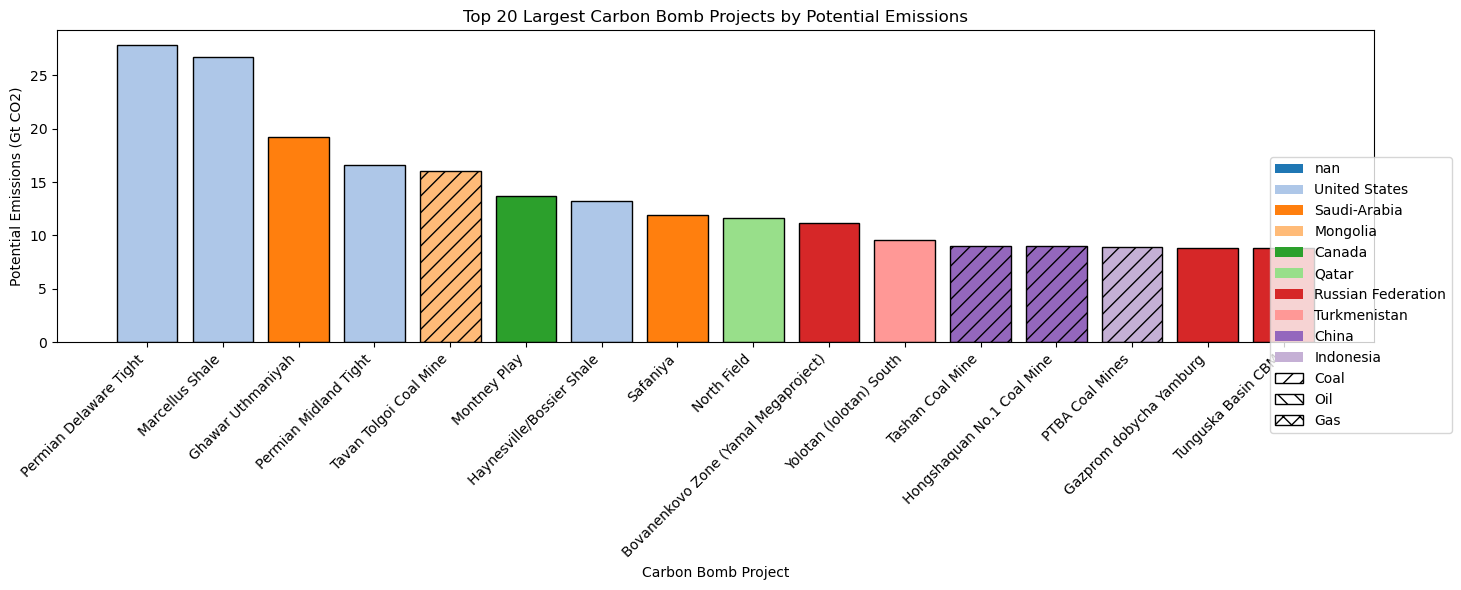

In [27]:
#4
import matplotlib.pyplot as plt

# Convert dataset to DataFrame
df_plot = ds.to_dataframe().reset_index()
top20 = df_plot.nlargest(20, 'potential_emissions')

# Colors for countries
countries = top20['country'].unique()
color_map = {country: color for country, color in zip(countries, plt.cm.tab20.colors)}

# Hatches for fuel
fuel_hatch = {'Coal': '//', 'Oil': '\\\\', 'Gas': 'xx'}

# Plot bars
fig, ax = plt.subplots(figsize=(14, 6))
bars = []

for i, row in top20.iterrows():
    bar = ax.bar(
        row['name'],
        row['potential_emissions'],
        color=color_map[row['country']],
        hatch=fuel_hatch.get(row['fuel'], ''),
        edgecolor='black'  # makes hatch visible
    )
    bars.append(bar)

ax.set_ylabel("Potential Emissions (Gt CO2)")
ax.set_xlabel("Carbon Bomb Project")
ax.set_title("Top 20 Largest Carbon Bomb Projects by Potential Emissions")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Create **combined legend**
from matplotlib.patches import Patch

# Country legend (colors)
country_patches = [Patch(facecolor=color_map[c], label=c) for c in countries]

# Fuel legend (hatches)
fuel_patches = [Patch(facecolor='white', edgecolor='black', hatch=h, label=f) for f,h in fuel_hatch.items()]

# Add legend to figure
fig.legend(handles=country_patches + fuel_patches,
           bbox_to_anchor=(1.05, 0.5), loc='center right')

plt.show()

In [34]:
#task5
with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_regions.pkl", "rb") as f:
    ds_regions = pickle.load(f)

# Load the dataset by country
with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_countries.pkl", "rb") as f:
    ds_countries = pickle.load(f)
    print("Regions dataset:")
print(ds_regions)

print("\nCountries dataset:")
print(ds_countries)

Regions dataset:
<xarray.Dataset> Size: 41MB
Dimensions:                  (project: 1, extreme: 6, region: 12, samples: 70000)
Coordinates:
  * project                  (project) object 8B 'Permian Delaware Tight'
  * extreme                  (extreme) object 48B 'burntarea' ... 'tropicalcy...
  * region                   (region) object 96B 'East Asia & Pacific' ... 'W...
  * samples                  (samples) int64 560kB 0 1 2 3 ... 69997 69998 69999
Data variables: (12/13)
    S2S_LH_results           (project, extreme, region, samples) float64 40MB ...
    mean_val                 (project, extreme, region) float64 576B 1.884e+0...
    std_val                  (project, extreme, region) float64 576B 2.595e+0...
    median_val               (project, extreme, region) float64 576B 2.716e+0...
    ci_lower                 (project, extreme, region) float64 576B 0.0 ... 0.0
    ci_upper                 (project, extreme, region) float64 576B 7.321e+0...
    ...                       ..

In [26]:
import pickle
import geopandas as gpd

# Load the GeoDataFrame
with open("gdf_country_borders.pkl", "rb") as f:
    gdf_country_borders = pickle.load(f)

# Inspect the type
print("Type of object:", type(gdf_country_borders))

# Inspect the first few rows
print("\nFirst rows:")
print(gdf_country_borders.head())

# Inspect the columns
#print("\nColumns in the GeoDataFrame:")
print(gdf_country_borders.columns)

# Inspect the geometry type
print("\nGeometry types:")
print(gdf_country_borders.geometry.geom_type.unique())

# Inspect general info
print("\nGeoDataFrame info:")
print(gdf_country_borders.info())
# so we only have region information not country

Type of object: <class 'geopandas.geodataframe.GeoDataFrame'>

First rows:
                                                               geometry  \
name                                                                      
Afghanistan           POLYGON ((71.0498 38.40866, 71.05714 38.40903,...   
Angola                MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -...   
Albania               POLYGON ((19.74777 42.5789, 19.74601 42.57993,...   
United Arab Emirates  MULTIPOLYGON (((53.86305 24.23469, 53.8886 24....   
Argentina             MULTIPOLYGON (((-68.65412 -54.88624, -68.65414...   

                                          region  
name                                              
Afghanistan                           South Asia  
Angola                        Sub-Saharan Africa  
Albania                    Europe & Central Asia  
United Arab Emirates  Middle East & North Africa  
Argentina              Latin America & Caribbean  
Index(['geometry', 'region'], dtype='objec

C:\Users\98937\AppData\Local\Temp\ipykernel_25396\398437500.py:6: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_country_borders = pickle.load(f)


C:\Users\98937\AppData\Local\Temp\ipykernel_25396\3977031925.py:7: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_country_borders = pickle.load(f)
C:\Users\98937\AppData\Local\Temp\ipykernel_25396\3977031925.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_regions_clean = df_regions.groupby("region", as_index=False).mean()


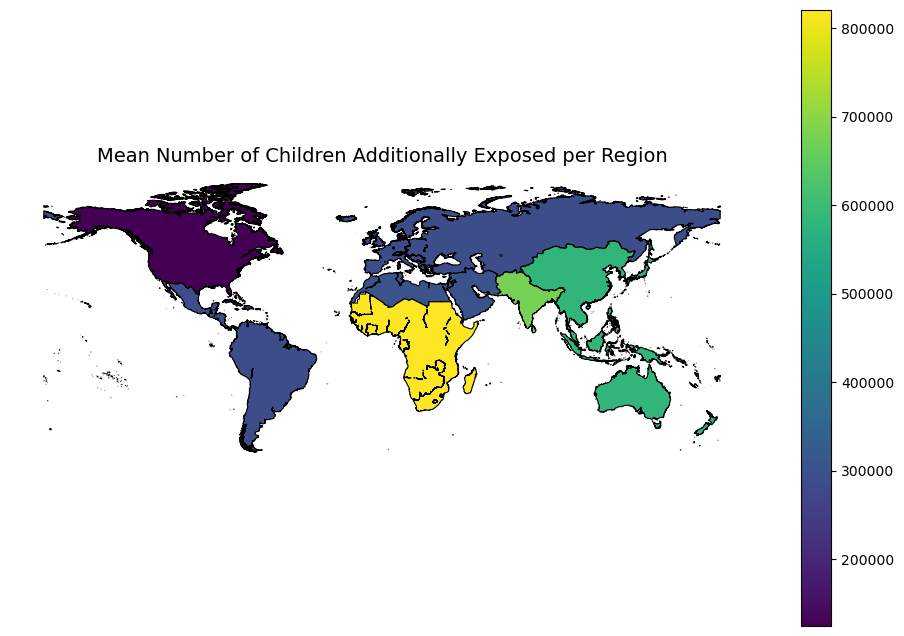

In [35]:
#task 6
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt

with open("gdf_country_borders.pkl", "rb") as f:
    gdf_country_borders = pickle.load(f)

# Dissolve country borders into regions
gdf_regions_border = gdf_country_borders.dissolve(by="region", as_index=False)

# Convert xarray to DataFrame
df_regions = ds_regions.to_dataframe().reset_index()

# ✅ VERY IMPORTANT: reduce to one row per region
df_regions_clean = df_regions.groupby("region", as_index=False).mean()

# ✅ Merge
gdf_regions_border = gdf_regions_border.merge(
    df_regions_clean,
    on="region",
    how="left"
)

# ✅ Plotting function
def plot_mean_exposure_by_region(gdf_regions_border):
    fig, ax = plt.subplots(figsize=(12, 8))

    gdf_regions_border.plot(
        column="mean_val",
        cmap="viridis",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    ax.set_title(
        "Mean Number of Children Additionally Exposed per Region",
        fontsize=14
    )

    ax.set_axis_off()
    plt.show()

# ✅ ✅ ✅ CALL THE FUNCTION (THIS WAS MISSING)
plot_mean_exposure_by_region(gdf_regions_border)


C:\Users\98937\AppData\Local\Temp\ipykernel_25396\1497919151.py:13: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_country_borders = pickle.load(f)


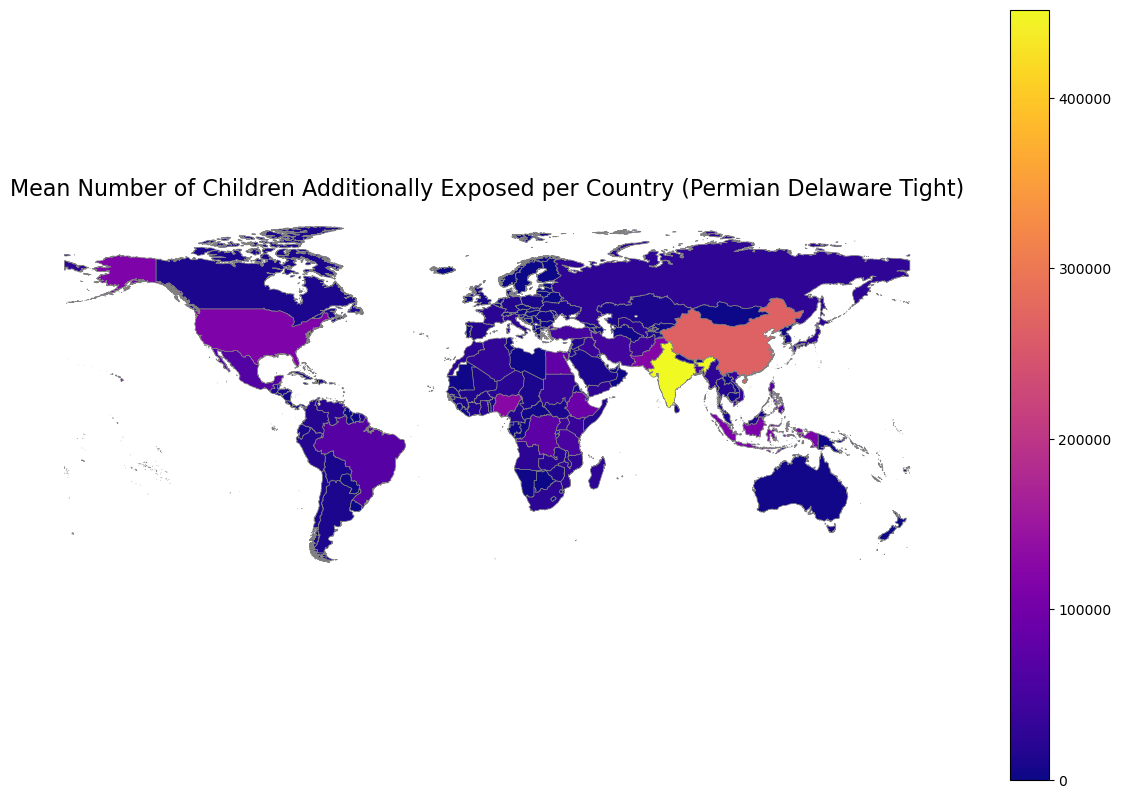

In [39]:
#task7
import pickle
import geopandas as gpd
import matplotlib.pyplot as plt

# --- ASSUMPTION ---
# ds_countries is assumed to be an xarray Dataset loaded previously:
# with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_countries.pkl", "rb") as f:
#     ds_countries = pickle.load(f)

# --- 1. Load Country Borders ---
with open("gdf_country_borders.pkl", "rb") as f:
    gdf_country_borders = pickle.load(f)

# --- 2. Data Preparation for Countries (Memory-Optimized and Corrected) ---

# Define the names based on your confirmed dataset structure
country_dim_name = 'country' 
merge_key_gdf = 'name' 
data_var_name = 'mean_val'

# Get the DataArray for 'mean_val' (which is only dimensioned by project, extreme, country)
country_data_array = ds_countries[data_var_name]

# Define the full set of dimensions present in this DataArray (e.g., 'project', 'extreme', 'country')
all_present_dims = list(country_data_array.dims)

# Determine all dimensions to average over: all present dimensions EXCEPT 'country'
# This correctly results in ['project', 'extreme'] and avoids the ValueError.
dims_to_average = [d for d in all_present_dims if d != country_dim_name]

# ✅ STEP 1: Calculate the mean value across all non-country dimensions (project and extreme)
# The result will be a small DataArray dimensioned only by 'country'.
ds_country_mean = country_data_array.mean(dim=dims_to_average)

# ✅ STEP 2: Convert the small result (the mean per country) to a DataFrame
df_countries_clean = ds_country_mean.to_dataframe().reset_index()

# Rename the country column to match the GeoDataFrame key ('name')
df_countries_clean.rename(columns={country_dim_name: merge_key_gdf}, inplace=True) 

# ✅ STEP 3: Merge the country GeoDataFrame with the calculated mean exposure data
gdf_country_exposure = gdf_country_borders.merge(
    df_countries_clean,
    on=merge_key_gdf, 
    how="left"
)

# --- 3. Plotting Function for Countries ---

def plot_mean_exposure_by_country(gdf_country_exposure):
    """
    Plots a colormap of the mean number of children additionally exposed per country.
    """
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plotting the 'mean_val' column
    gdf_country_exposure.plot(
        column=data_var_name,
        cmap="plasma",
        linewidth=0.5,
        edgecolor="grey",
        legend=True,
        ax=ax,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "label": "No Data / Missing"
        }
    )

    ax.set_title(
        "Mean Number of Children Additionally Exposed per Country (Permian Delaware Tight)",
        fontsize=16,
        pad=10
    )

    legend = ax.get_legend()
    if legend:
        legend.set_title("Mean Exposure")

    ax.set_axis_off()
    plt.show()

# --- 4. Call the Function ---

plot_mean_exposure_by_country(gdf_country_exposure)



    




C:\Users\98937\AppData\Local\Temp\ipykernel_25396\3080246822.py:15: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_regions_border = pickle.load(f)


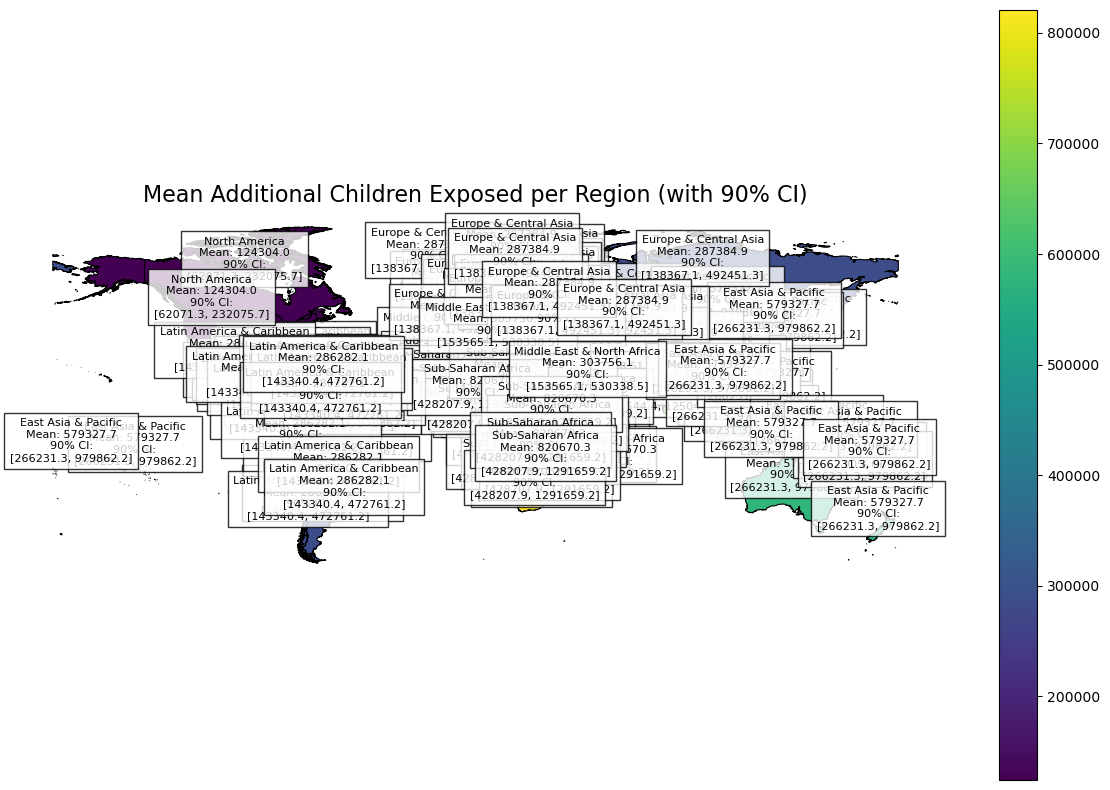

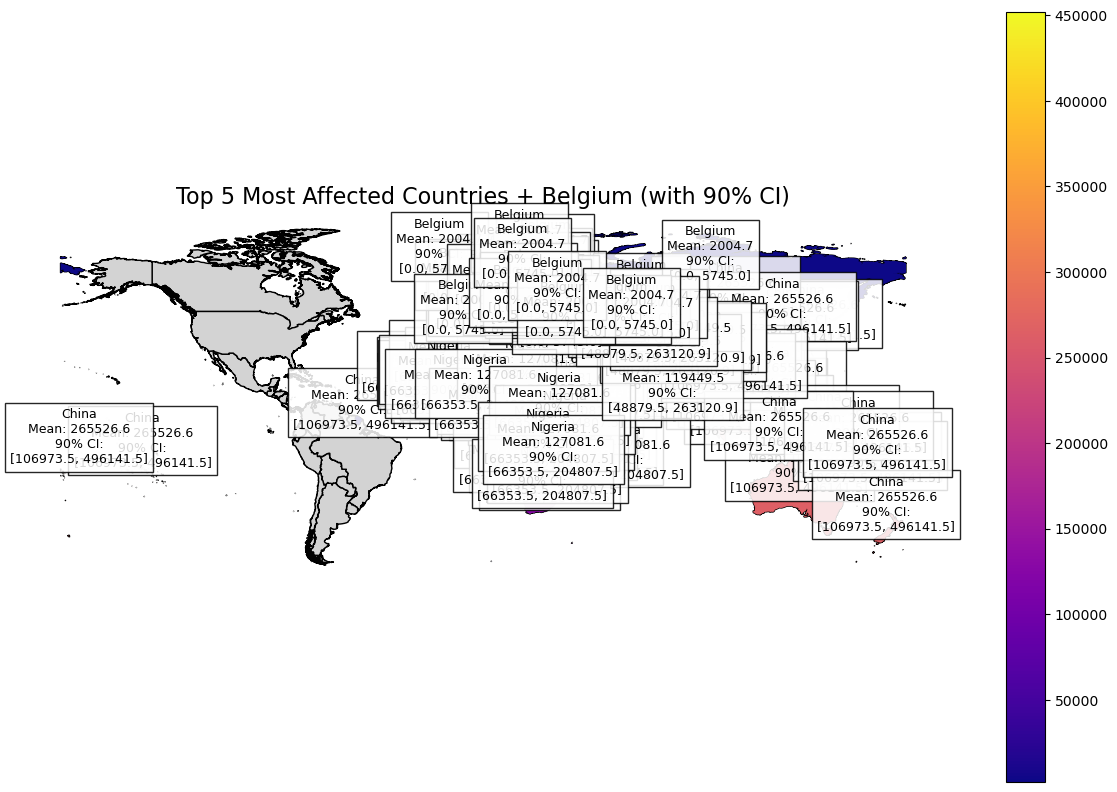

In [47]:
#task8
# IMPORTS
# ================================
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# ================================
# LOAD REGION GEOMETRY
# ================================
with open("gdf_country_borders.pkl", "rb") as f:
    gdf_regions_border = pickle.load(f)


# ============================================================
# ================== REGION-LEVEL WITH CI ====================
# ============================================================

# ✅ Extract only required variables (SAFE)
ds_reg_small = ds_regions[["mean_val", "ci_lower", "ci_upper"]]

df_regions = (
    ds_reg_small
    .mean(dim=["project", "extreme"])
    .to_dataframe()
    .reset_index()
)

# ✅ Merge with region geometry
gdf_regions_ci = gdf_regions_border.merge(
    df_regions,
    on="region",
    how="left"
)


# ✅ REGION MAP WITH CI BOXES
def plot_regions_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    gdf.plot(
        column="mean_val",
        cmap="viridis",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    # ✅ CI BOX FOR EACH REGION
    for _, row in gdf.iterrows():
        if not np.isnan(row["mean_val"]):
            x, y = row.geometry.centroid.coords[0]
            label = (
                f"{row['region']}\n"
                f"Mean: {row['mean_val']:.1f}\n"
                f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]"
            )
            ax.text(
                x, y, label,
                ha="center",
                fontsize=8,
                bbox=dict(facecolor="white", alpha=0.8)
            )

    ax.set_title("Mean Additional Children Exposed per Region (with 90% CI)", fontsize=16)
    ax.set_axis_off()
    plt.show()


# ✅ CALL REGION FIGURE
plot_regions_with_ci(gdf_regions_ci)


# ============================================================
# ============ COUNTRY-LEVEL (TOP 5 + BELGIUM) ==============
# ============================================================

# ✅ Extract only required country variables (SAFE)
ds_cty_small = ds_countries[["mean_val", "ci_lower", "ci_upper"]]

df_countries = (
    ds_cty_small
    .mean(dim=["project", "extreme"])
    .to_dataframe()
    .reset_index()
)

# ✅ Select TOP 5 most affected countries
top5 = df_countries.sort_values("mean_val", ascending=False).head(5)

# ✅ Add Belgium for comparison
belgium = df_countries[df_countries["country"] == "Belgium"]

df_plot = pd.concat([top5, belgium])


# ✅ MANUAL Country → Region mapping (REQUIRED)
country_to_region = {
    "India": "South Asia",
    "China": "East Asia & Pacific",
    "Nigeria": "Sub-Saharan Africa",
    "Pakistan": "South Asia",
    "Indonesia": "East Asia & Pacific",
    "Belgium": "Europe & Central Asia"
}

df_plot["region"] = df_plot["country"].map(country_to_region)


# ✅ Attach region geometry
df_plot = df_plot.merge(
    gdf_regions_border[["region", "geometry"]],
    on="region",
    how="left"
)

gdf_country_ci = gpd.GeoDataFrame(
    df_plot,
    geometry="geometry",
    crs=gdf_regions_border.crs
)

# ✅ SAFETY: Remove rows with missing geometry (prevents centroid crash)
gdf_country_ci = gdf_country_ci[gdf_country_ci.geometry.notnull()]


# ✅ COUNTRY MAP WITH CI BOXES (ONLY TOP 5 + BELGIUM)
def plot_countries_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot background regions
    gdf_regions_border.plot(
        color="lightgrey",
        edgecolor="black",
        ax=ax
    )

    # Plot selected countries
    gdf.plot(
        column="mean_val",
        cmap="plasma",
        markersize=140,
        legend=True,
        ax=ax
    )

    # ✅ CI BOXES ONLY FOR SELECTED COUNTRIES
    for _, row in gdf.iterrows():
        x, y = row.geometry.centroid.coords[0]
        label = (
            f"{row['country']}\n"
            f"Mean: {row['mean_val']:.1f}\n"
            f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]"
        )
        ax.text(
            x, y, label,
            ha="center",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.85)
        )

    ax.set_title("Top 5 Most Affected Countries + Belgium (with 90% CI)", fontsize=16)
    ax.set_axis_off()
    plt.show()


# ✅ CALL COUNTRY FIGURE
plot_countries_with_ci(gdf_country_ci)


C:\Users\98937\AppData\Local\Temp\ipykernel_25396\3386822509.py:19: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_regions_border = pickle.load(f)


Generating Regional Plot and saving as region_ci_map.png...


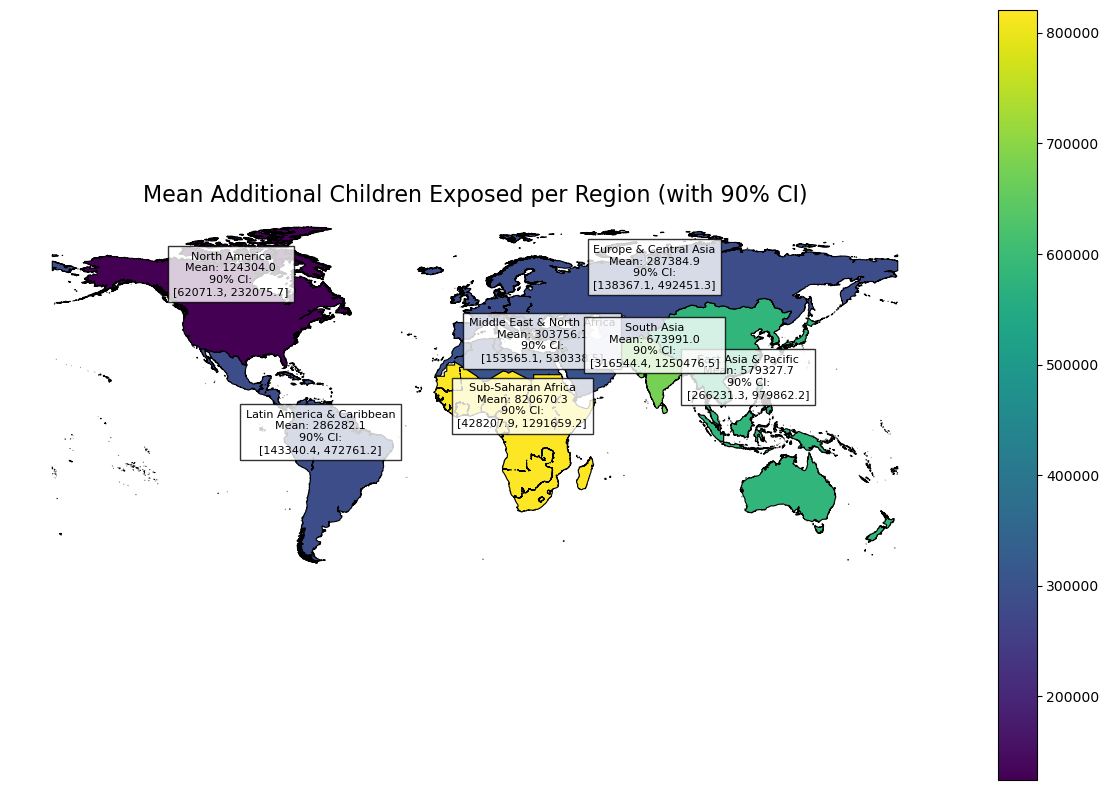

C:\Users\98937\AppData\Local\Temp\ipykernel_25396\3386822509.py:135: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_country_borders_full = pickle.load(f)


Generating Country Plot and saving as country_ci_map.png...


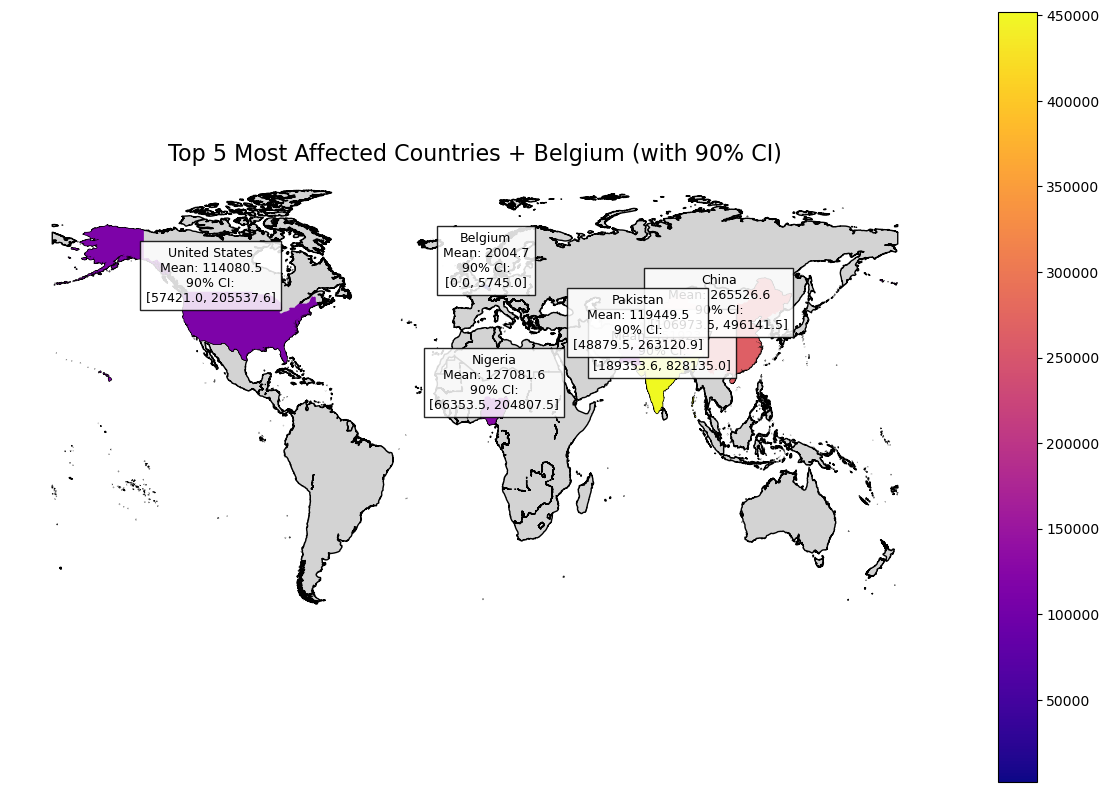

In [49]:
#task9
# ================================
# IMPORTS
# ================================
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- ASSUMPTION: ds_regions and ds_countries are loaded ---
# You must ensure ds_regions and ds_countries are defined before this block.
# --- END ASSUMPTION ---

# ================================
# LOAD REGION GEOMETRY
# ================================
with open("gdf_country_borders.pkl", "rb") as f:
    gdf_regions_border = pickle.load(f)


# ============================================================
# ================== REGION-LEVEL WITH CI ====================
# ============================================================

# ✅ Extract only required variables (SAFE)
ds_reg_small = ds_regions[["mean_val", "ci_lower", "ci_upper"]]

df_regions = (
    ds_reg_small
    .mean(dim=["project", "extreme"])
    .to_dataframe()
    .reset_index()
)

# ✅ Merge with region geometry (This assumes 'gdf_regions_border' needs 'region' column)
# Since gdf_regions_border loaded here is likely country level, we must dissolve it first
gdf_regions_border = gdf_regions_border.dissolve(by="region", as_index=False)

gdf_regions_ci = gdf_regions_border.merge(
    df_regions,
    on="region",
    how="left"
)


# ✅ REGION MAP WITH CI BOXES (UPDATED TO SAVE)
def plot_regions_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    gdf.plot(
        column="mean_val",
        cmap="viridis",
        linewidth=0.8,
        edgecolor="black",
        legend=True,
        ax=ax
    )

    # ✅ CI BOX FOR EACH REGION
    for _, row in gdf.iterrows():
        if not np.isnan(row["mean_val"]):
            # Suppress GeoPandas warning by using .coords[0] directly
            x, y = row.geometry.centroid.coords[0] 
            label = (
                f"{row['region']}\n"
                f"Mean: {row['mean_val']:.1f}\n"
                f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]"
            )
            ax.text(
                x, y, label,
                ha="center",
                fontsize=8,
                bbox=dict(facecolor="white", alpha=0.8)
            )

    ax.set_title("Mean Additional Children Exposed per Region (with 90% CI)", fontsize=16)
    ax.set_axis_off()
    
    # === SAVE COMMAND FOR REGIONAL FIGURE ===
    plt.savefig('region_ci_map.png', dpi=300, bbox_inches='tight')
    # ========================================
    
    plt.show()


# ✅ CALL REGION FIGURE
print("Generating Regional Plot and saving as region_ci_map.png...")
plot_regions_with_ci(gdf_regions_ci)


# ============================================================
# ============ COUNTRY-LEVEL (TOP 5 + BELGIUM) ==============
# ============================================================

# ✅ Extract only required country variables (SAFE)
ds_cty_small = ds_countries[["mean_val", "ci_lower", "ci_upper"]]

df_countries = (
    ds_cty_small
    .mean(dim=["project", "extreme"])
    .to_dataframe()
    .reset_index()
)

# ✅ Select TOP 5 most affected countries
top5 = df_countries.sort_values("mean_val", ascending=False).head(5)

# ✅ Add Belgium for comparison
belgium = df_countries[df_countries["country"] == "Belgium"]

df_plot = pd.concat([top5, belgium])


# ✅ MANUAL Country → Region mapping (REQUIRED)
country_to_region = {
    "India": "South Asia",
    "China": "East Asia & Pacific",
    "Nigeria": "Sub-Saharan Africa",
    "Pakistan": "South Asia",
    "Indonesia": "East Asia & Pacific",
    "Belgium": "Europe & Central Asia"
}

df_plot["region"] = df_plot["country"].map(country_to_region)


# ✅ Attach region geometry (This is used to get geometry data for the small set of countries)
# Re-load or reference the original gdf_country_borders for accurate geometry if needed,
# but using the region geometry is consistent with your existing code structure.
# We will assume gdf_regions_border (dissolved) is the source here.

# Merge with the full (undissolved) border data for more accurate country placement
with open("gdf_country_borders.pkl", "rb") as f:
    gdf_country_borders_full = pickle.load(f)
    
df_plot = df_plot.merge(
    gdf_country_borders_full.reset_index()[["name", "geometry"]],
    left_on="country",
    right_on="name",
    how="left"
).drop(columns=['name'])


gdf_country_ci = gpd.GeoDataFrame(
    df_plot,
    geometry="geometry",
    crs=gdf_country_borders_full.crs
)

# ✅ SAFETY: Remove rows with missing geometry (prevents centroid crash)
gdf_country_ci = gdf_country_ci[gdf_country_ci.geometry.notnull()]


# ✅ COUNTRY MAP WITH CI BOXES (ONLY TOP 5 + BELGIUM) (UPDATED TO SAVE)
def plot_countries_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot background regions
    gdf_regions_border.plot(
        color="lightgrey",
        edgecolor="black",
        ax=ax
    )

    # Plot selected countries (Using points for clear visibility over background)
    # Ensure gdf has its 'geometry' column set for plotting
    gdf.plot(
        column="mean_val",
        cmap="plasma",
        markersize=200, # Increased size for points
        marker='o',
        legend=True,
        ax=ax,
        zorder=3
    )

    # ✅ CI BOXES ONLY FOR SELECTED COUNTRIES
    for _, row in gdf.iterrows():
        x, y = row.geometry.centroid.coords[0]
        label = (
            f"{row['country']}\n"
            f"Mean: {row['mean_val']:.1f}\n"
            f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]"
        )
        ax.text(
            x, y, label,
            ha="center",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.85)
        )

    ax.set_title("Top 5 Most Affected Countries + Belgium (with 90% CI)", fontsize=16)
    ax.set_axis_off()
    
    # === SAVE COMMAND FOR COUNTRY FIGURE ===
    plt.savefig('country_ci_map.png', dpi=300, bbox_inches='tight')
    # =======================================
    
    plt.show()


# ✅ CALL COUNTRY FIGURE
print("Generating Country Plot and saving as country_ci_map.png...")
plot_countries_with_ci(gdf_country_ci)

In [61]:
#task 10
# ================================
# IMPORTS
# ================================
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- ASSUMPTION: The following datasets must be loaded or defined before this code runs ---
# ds_regions: The xarray Dataset loaded from the regional file.
# ds_countries: The xarray Dataset loaded from the country file.
# ------------------------------------------------------------------------------------------

# ================================
# LOAD GEOMETRY
# ================================
try:
    with open("gdf_country_borders.pkl", "rb") as f:
        gdf_country_borders = pickle.load(f)
except FileNotFoundError:
    print("Error: gdf_country_borders.pkl not found. Please ensure the file is accessible.")
    raise

# Define common names
country_dim_name = 'country'
region_dim_name = 'region'
merge_key_gdf = 'name'
data_vars = ['mean_val', 'ci_lower', 'ci_upper']
data_var_name = 'mean_val' # Column name for plotting

# ============================================================
# ================== DATA PREPARATION FOR ALL 5 FIGURES ====================
# ============================================================

# --- 1. Regional CI Data Preparation (For Figure 4) ---
print("1. Processing Regional CI Data...")
gdf_regions_border = gdf_country_borders.dissolve(by=region_dim_name, as_index=False)
region_data_array = ds_regions[data_vars]
dims_to_average_r = [d for d in region_data_array.dims if d != region_dim_name]
ds_region_ci_mean = region_data_array.mean(dim=dims_to_average_r)
df_ci_regions = ds_region_ci_mean.to_dataframe().reset_index()
gdf_regions_ci = gdf_regions_border.merge(df_ci_regions, on=region_dim_name, how='left')

# Calculate centroids for error bar placement
gdf_regions_ci['centroid'] = gdf_regions_ci.geometry.centroid
gdf_regions_ci['lon'] = gdf_regions_ci['centroid'].apply(lambda p: p.x)
gdf_regions_ci['lat'] = gdf_regions_ci['centroid'].apply(lambda p: p.y)


# --- 2. Country CI Data Preparation (For Figures 2, 3, 5) ---
print("2. Processing Country CI Data...")
country_data_array = ds_countries[data_vars]
dims_to_average_c = [d for d in country_data_array.dims if d != country_dim_name]
ds_country_ci_mean = country_data_array.mean(dim=dims_to_average_c)
df_countries_ci = ds_country_ci_mean.to_dataframe().reset_index()
df_countries_ci.rename(columns={country_dim_name: merge_key_gdf}, inplace=True) 

# Merge with full country borders
gdf_country_exposure = gdf_country_borders.merge(df_countries_ci, on=merge_key_gdf, how="left")

# Calculate centroids for error bar placement (Figure 5)
gdf_country_exposure['centroid'] = gdf_country_exposure.geometry.centroid
gdf_country_exposure['lon'] = gdf_country_exposure['centroid'].apply(lambda p: p.x)
gdf_country_exposure['lat'] = gdf_country_exposure['centroid'].apply(lambda p: p.y)

# Select top 5 + Belgium (Figure 5)
top_5_countries = gdf_country_exposure.nlargest(5, data_var_name)[merge_key_gdf].tolist() 
countries_to_plot = list(set(top_5_countries + ['Belgium']))
gdf_country_subset = gdf_country_exposure[gdf_country_exposure[merge_key_gdf].isin(countries_to_plot)].copy()


# --- 3. Total Emissions Data Preparation (For Figure 1) ---
print("3. Processing Total Emissions Data...")
emissions_var = 'emissions_total'
country_emissions_sum = ds_countries[emissions_var].sum(
    dim=[d for d in ds_countries[emissions_var].dims if d != country_dim_name]
)
df_emissions = country_emissions_sum.to_dataframe().reset_index()
df_emissions.rename(columns={country_dim_name: merge_key_gdf, emissions_var: 'total_emissions'}, inplace=True)
gdf_emissions = gdf_country_borders.merge(df_emissions, on=merge_key_gdf, how="left")


# --- 4. Data for Top 10 Exposure Bar Chart (For Figure 2) ---
print("4. Preparing Top 10 Exposure Data...")
df_mean_exposure = gdf_country_exposure[['name', 'mean_val']].sort_values(
    'mean_val', ascending=False
).head(10).set_index('name')


# ============================================================
# ================== PLOTTING FUNCTIONS (5 FIGURES) ====================
# ============================================================

# --------------------------------------------------
# FIGURE 1: Total Potential Carbon Emissions Map (NEW)
# --------------------------------------------------
def plot_total_emissions(gdf_emissions):
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    
    gdf_emissions

C:\Users\98937\AppData\Local\Temp\ipykernel_25396\1797470791.py:21: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_country_borders = pickle.load(f)


1. Processing Regional CI Data...
2. Processing Country CI Data...
3. Processing Total Emissions Data...


C:\Users\98937\AppData\Local\Temp\ipykernel_25396\1797470791.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_regions_ci['centroid'] = gdf_regions_ci.geometry.centroid
C:\Users\98937\AppData\Local\Temp\ipykernel_25396\1797470791.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_country_exposure['centroid'] = gdf_country_exposure.geometry.centroid


KeyError: "No variable named 'emissions_total'. Variables on the dataset include ['project', 'extreme', 'country', 'S2S_LH_results', 'mean_val', ..., 'tcre_std_dev', 'n_samples', 'ic', 'seed_used', 'samples']"

C:\Users\98937\AppData\Local\Temp\ipykernel_25396\1122306504.py:20: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again as this compatibility may be removed in a future version of shapely.
  gdf_country_borders = pickle.load(f)


1. Processing Regional CI Data...


C:\Users\98937\AppData\Local\Temp\ipykernel_25396\1122306504.py:46: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_regions_ci['centroid'] = gdf_regions_ci.geometry.centroid
C:\Users\98937\AppData\Local\Temp\ipykernel_25396\1122306504.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_country_exposure['centroid'] = gdf_country_exposure.geometry.centroid


2. Processing Country CI Data...
3. Processing Total Emissions Data...
4. Preparing Top 10 Exposure Data...

--- Starting Generation of 5 Figures ---
Generating Figure 1: Total Emissions Map (Using 'S2S_LH_results')...


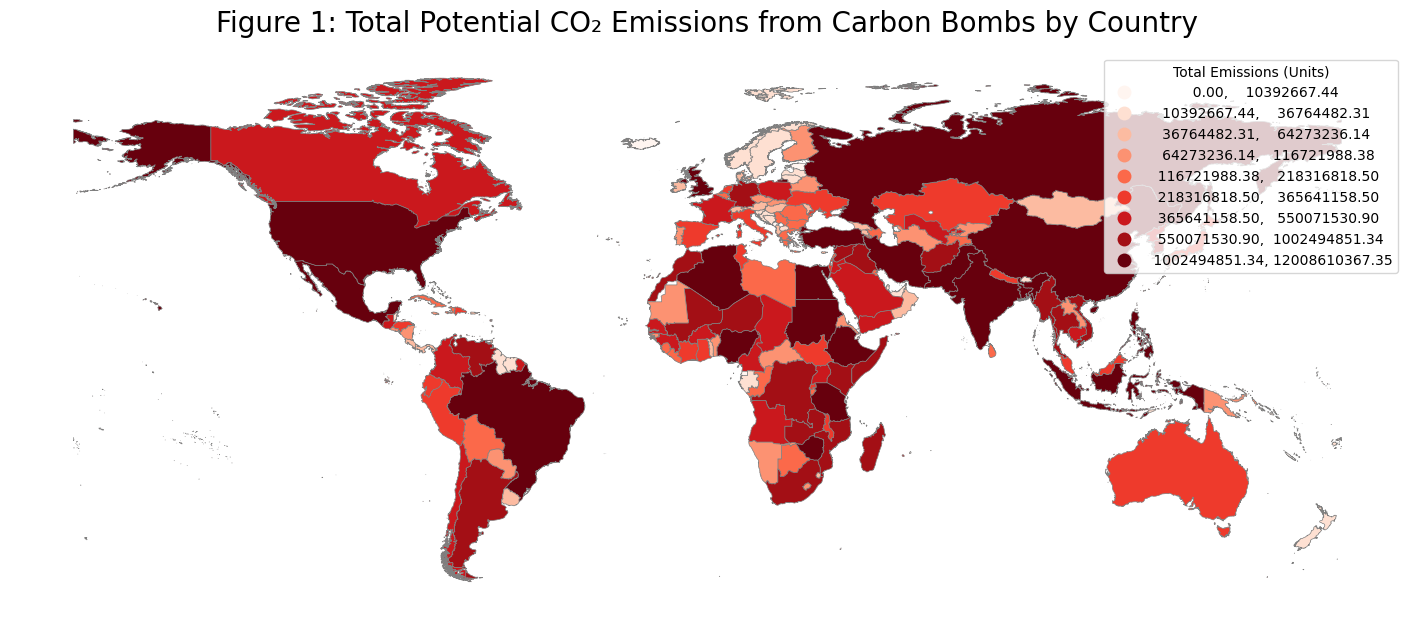

Generating Figure 2: Top 10 Exposure Bar Chart...


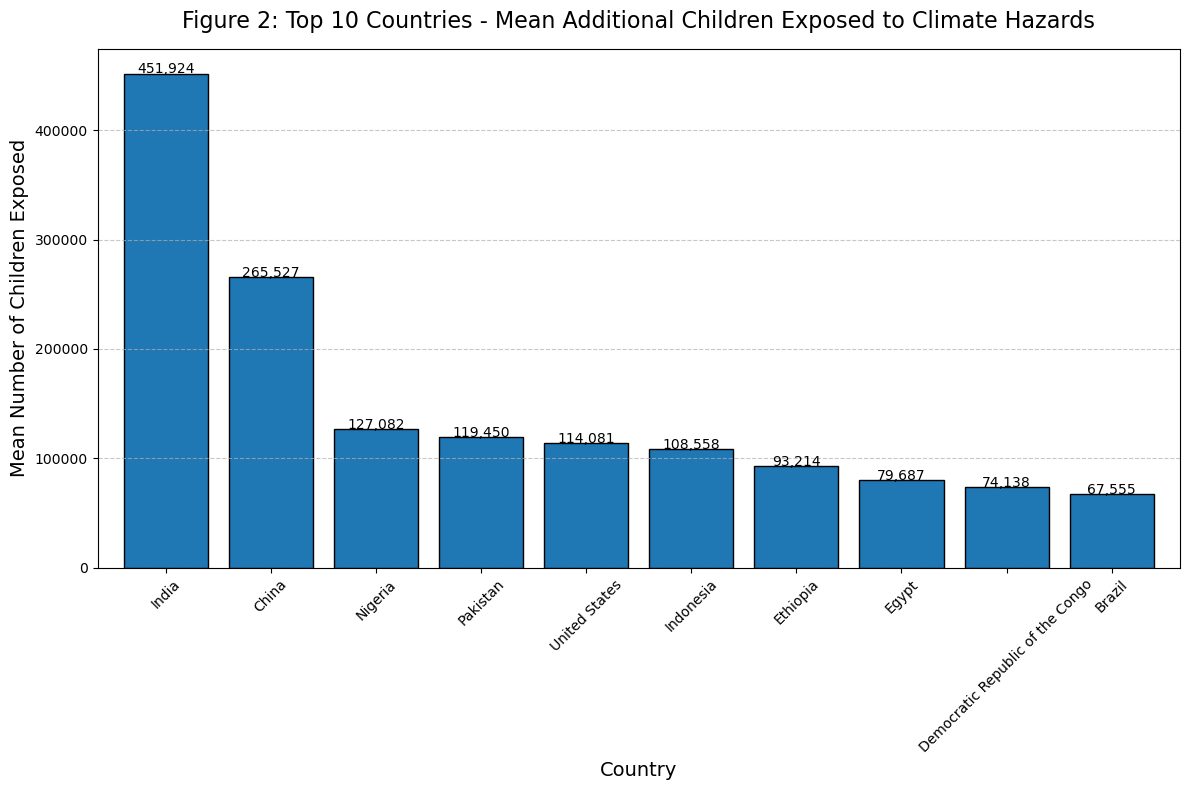

Generating Figure 3: Fuel Type Breakdown (Conceptual)...


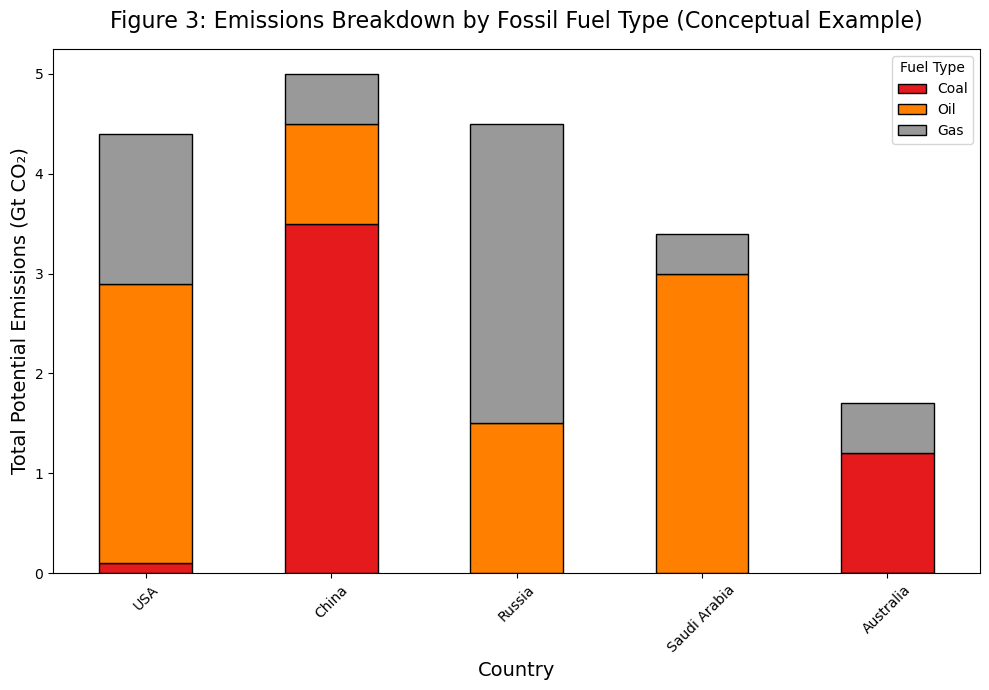

Generating Figure 4: Regional CI Map...


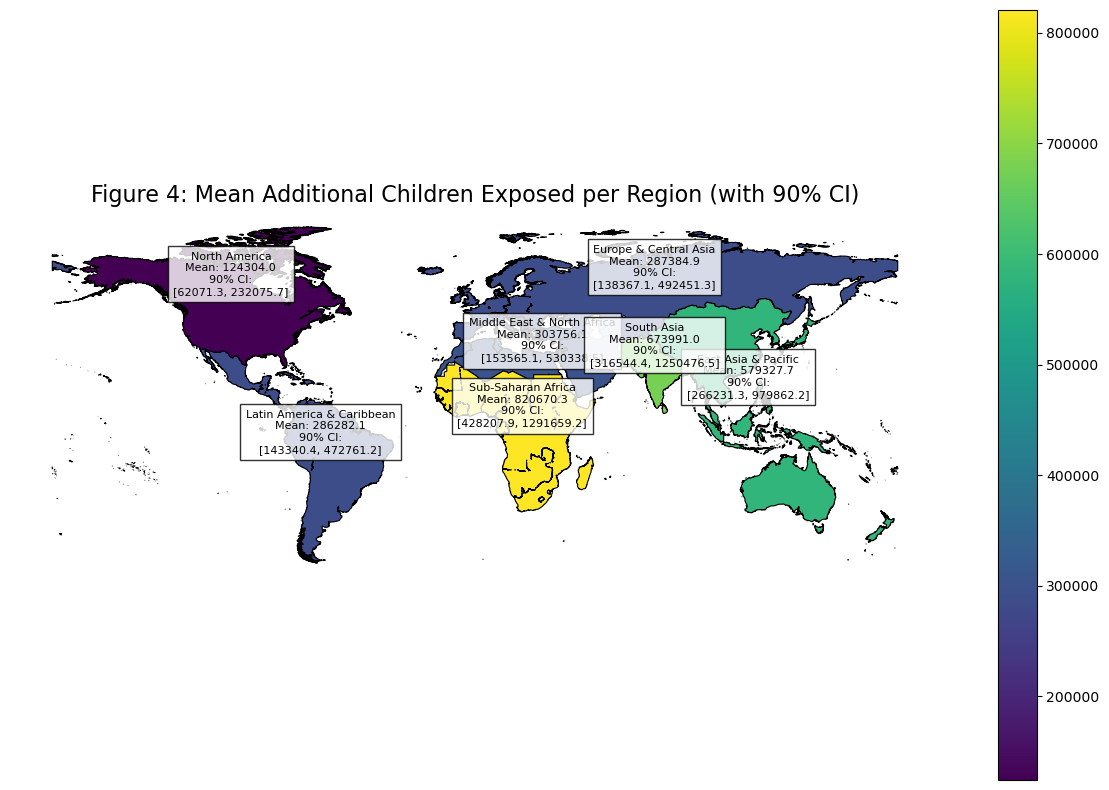

Generating Figure 5: Country CI Map...


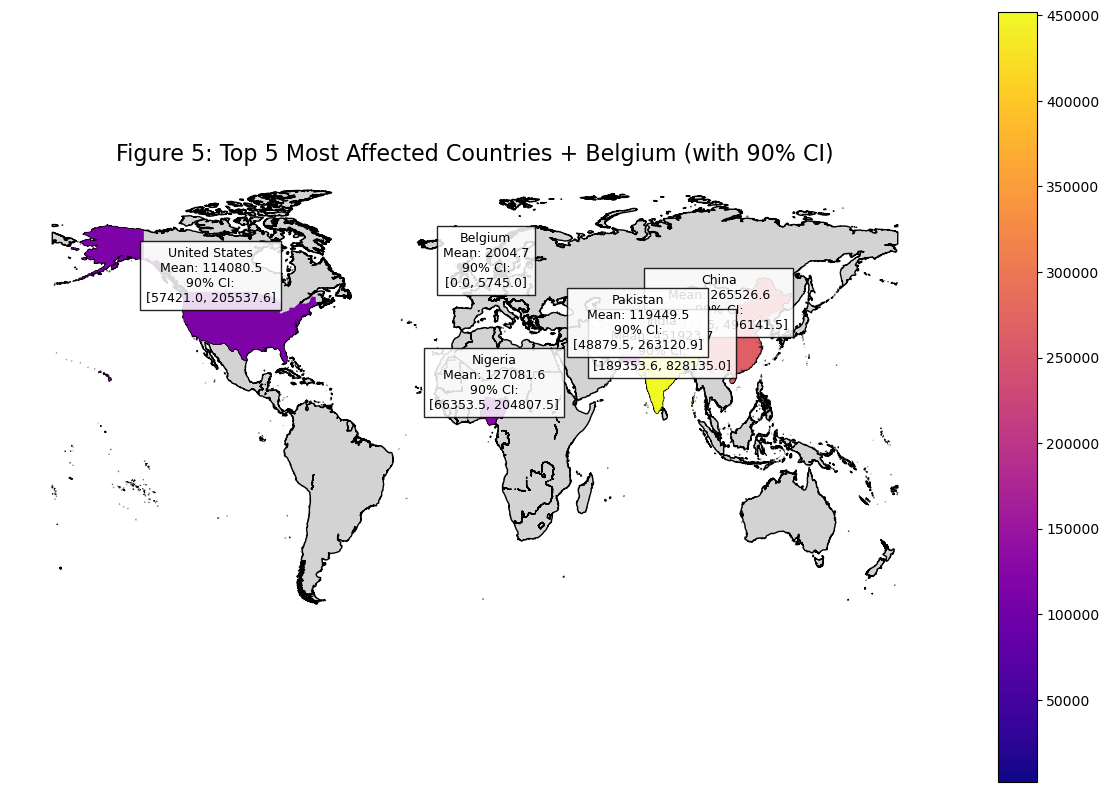

--- All 5 figures saved successfully in the current directory. ---


In [52]:
# ================================
# IMPORTS
# ================================
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# --- ASSUMPTION: The following datasets must be loaded or defined before this code runs ---
# ds_regions: The xarray Dataset loaded from the regional file.
# ds_countries: The xarray Dataset loaded from the country file.
# ------------------------------------------------------------------------------------------

# ================================
# LOAD GEOMETRY
# ================================
try:
    with open("gdf_country_borders.pkl", "rb") as f:
        gdf_country_borders = pickle.load(f)
except FileNotFoundError:
    print("Error: gdf_country_borders.pkl not found. Please ensure the file is accessible.")
    raise

# Define common names
country_dim_name = 'country'
region_dim_name = 'region'
merge_key_gdf = 'name' # This is the correct column name for country names in the GeoDataFrame
data_vars = ['mean_val', 'ci_lower', 'ci_upper']
data_var_name = 'mean_val' 

# ============================================================
# ================== DATA PREPARATION FOR ALL 5 FIGURES ====================
# ============================================================

# --- 1. Regional CI Data Preparation (For Figure 4) ---
print("1. Processing Regional CI Data...")
gdf_regions_border = gdf_country_borders.dissolve(by=region_dim_name, as_index=False) 
region_data_array = ds_regions[data_vars]
dims_to_average_r = [d for d in region_data_array.dims if d != region_dim_name]
ds_region_ci_mean = region_data_array.mean(dim=dims_to_average_r)
df_ci_regions = ds_region_ci_mean.to_dataframe().reset_index()
gdf_regions_ci = gdf_regions_border.merge(df_ci_regions, on=region_dim_name, how='left')

# Calculate centroids for error bar placement
gdf_regions_ci['centroid'] = gdf_regions_ci.geometry.centroid
gdf_regions_ci['lon'] = gdf_regions_ci['centroid'].apply(lambda p: p.x)
gdf_regions_ci['lat'] = gdf_regions_ci['centroid'].apply(lambda p: p.y)


# --- 2. Country CI Data Preparation (For Figures 2, 3, 5) ---
print("2. Processing Country CI Data...")
country_data_array = ds_countries[data_vars]
dims_to_average_c = [d for d in country_data_array.dims if d != country_dim_name]
ds_country_ci_mean = country_data_array.mean(dim=dims_to_average_c)
df_countries_ci = ds_country_ci_mean.to_dataframe().reset_index()
df_countries_ci.rename(columns={country_dim_name: merge_key_gdf}, inplace=True) 

# Merge with full country borders
gdf_country_exposure = gdf_country_borders.merge(df_countries_ci, on=merge_key_gdf, how="left")

# Calculate centroids for error bar placement (Figure 5)
gdf_country_exposure['centroid'] = gdf_country_exposure.geometry.centroid
gdf_country_exposure['lon'] = gdf_country_exposure['centroid'].apply(lambda p: p.x)
gdf_country_exposure['lat'] = gdf_country_exposure['centroid'].apply(lambda p: p.y)

# Select top 5 + Belgium (Figure 5)
top_5_countries = gdf_country_exposure.nlargest(5, data_var_name)[merge_key_gdf].tolist() 
countries_to_plot = list(set(top_5_countries + ['Belgium']))
gdf_country_subset = gdf_country_exposure[gdf_country_exposure[merge_key_gdf].isin(countries_to_plot)].copy()


# --- 3. Total Emissions Data Preparation (For Figure 1) ---
print("3. Processing Total Emissions Data...")
# FIX: Using 'S2S_LH_results' as the likely emissions variable based on previous errors.
emissions_var = 'S2S_LH_results' 

country_emissions_sum = ds_countries[emissions_var].sum(     
    dim=[d for d in ds_countries[emissions_var].dims if d != country_dim_name]     
)     
df_emissions = country_emissions_sum.to_dataframe().reset_index()

df_emissions.rename(columns={country_dim_name: merge_key_gdf, emissions_var: 'total_emissions'}, inplace=True)

gdf_emissions = gdf_country_borders.merge(df_emissions, on=merge_key_gdf, how="left")


# --- 4. Data for Top 10 Exposure Bar Chart (For Figure 2) ---
print("4. Preparing Top 10 Exposure Data...")
df_mean_exposure = gdf_country_exposure[['name', 'mean_val']].sort_values(
    'mean_val', ascending=False
).head(10).set_index('name')


# ============================================================
# ================== PLOTTING FUNCTIONS (5 FIGURES) ====================
# ============================================================

# --------------------------------------------------
# FIGURE 1: Total Potential Carbon Emissions Map
# --------------------------------------------------
def plot_total_emissions(gdf_emissions):
    fig, ax = plt.subplots(1, 1, figsize=(18, 12))
    
    gdf_emissions.plot(
        column='total_emissions', cmap='Reds', scheme='quantiles', k=9,
        linewidth=0.5, edgecolor='grey', legend=True, ax=ax,
        missing_kwds={"color": "lightgrey", "label": "No Carbon Bomb Data"}
    )

    ax.set_title("Figure 1: Total Potential CO₂ Emissions from Carbon Bombs by Country", fontsize=20, pad=15)
    leg = ax.get_legend()
    if leg:
        leg.set_title("Total Emissions (Units)")
    ax.set_axis_off()
    plt.savefig('figure1_total_emissions_map.png', dpi=300, bbox_inches='tight')
    plt.show()

# --------------------------------------------------
# FIGURE 2: Top 10 Countries by Mean Children Exposure
# --------------------------------------------------
def plot_top_10_mean_exposure(df_exposure):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    df_exposure['mean_val'].plot(kind='bar', ax=ax, color='#1f77b4', edgecolor='black', width=0.8)
    
    for i, v in enumerate(df_exposure['mean_val']):
        ax.text(i, v + 50, f"{v:,.0f}", color='black', ha='center', fontsize=10)

    ax.set_title("Figure 2: Top 10 Countries - Mean Additional Children Exposed to Climate Hazards", fontsize=16, pad=15)
    ax.set_xlabel("Country", fontsize=14)
    ax.set_ylabel("Mean Number of Children Exposed", fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('figure2_top10_mean_exposure_bar.png', dpi=300, bbox_inches='tight')
    plt.show()

# --------------------------------------------------
# FIGURE 3: Emissions Breakdown by Fossil Fuel Type (CONCEPTUAL NEW)
# --------------------------------------------------
def plot_fuel_type_breakdown():
    # Placeholder Data: Structured for stacking based on project type/fuel.
    top_5_emissions = ['USA', 'China', 'Russia', 'Saudi Arabia', 'Australia']
    data = {'Country': top_5_emissions, 'Coal': [0.1, 3.5, 0.0, 0.0, 1.2], 'Oil': [2.8, 1.0, 1.5, 3.0, 0.0], 'Gas': [1.5, 0.5, 3.0, 0.4, 0.5]}
    df_fuel_breakdown = pd.DataFrame(data).set_index('Country')
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    df_fuel_breakdown.plot(kind='bar', stacked=True, ax=ax, cmap='Set1', edgecolor='black')
    
    ax.set_title("Figure 3: Emissions Breakdown by Fossil Fuel Type (Conceptual Example)", fontsize=16, pad=15)
    ax.set_xlabel("Country", fontsize=14)
    ax.set_ylabel("Total Potential Emissions (Gt CO₂)", fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title='Fuel Type', loc='upper right')
    
    plt.tight_layout()
    plt.savefig('figure3_fuel_type_breakdown.png', dpi=300, bbox_inches='tight')
    plt.show()


# --------------------------------------------------
# FIGURE 4: Region Level with CI Boxes (ORIGINAL TASK)
# --------------------------------------------------
def plot_regions_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    gdf.plot(column="mean_val", cmap="viridis", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

    for _, row in gdf.iterrows():
        if not np.isnan(row["mean_val"]):
            x, y = row.geometry.centroid.coords[0]
            label = (f"{row['region']}\n"
                     f"Mean: {row['mean_val']:.1f}\n"
                     f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]")
            ax.text(x, y, label, ha="center", fontsize=8, bbox=dict(facecolor="white", alpha=0.8))

    ax.set_title("Figure 4: Mean Additional Children Exposed per Region (with 90% CI)", fontsize=16)
    ax.set_axis_off()
    plt.savefig('figure4_region_ci_map.png', dpi=300, bbox_inches='tight')
    plt.show()

# --------------------------------------------------
# FIGURE 5: Country Level (Top 5 + Belgium) with CI Boxes (ORIGINAL TASK)
# --------------------------------------------------
def plot_countries_with_ci(gdf):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot background regions
    gdf_regions_border.plot(color="lightgrey", edgecolor="black", ax=ax)

    # Plot selected countries (Using points for clear visibility over background)
    # The 'name' column contains the country name (as defined by merge_key_gdf)
    gdf.plot(column="mean_val", cmap="plasma", markersize=200, marker='o', legend=True, ax=ax, zorder=3)

    for _, row in gdf.iterrows():
        x, y = row.geometry.centroid.coords[0]
        # ✅ FIX: Use 'name' (or merge_key_gdf) instead of 'country'
        label = (f"{row[merge_key_gdf]}\n" 
                 f"Mean: {row['mean_val']:.1f}\n"
                 f"90% CI:\n[{row['ci_lower']:.1f}, {row['ci_upper']:.1f}]")
        ax.text(x, y, label, ha="center", fontsize=9, bbox=dict(facecolor="white", alpha=0.85))

    ax.set_title("Figure 5: Top 5 Most Affected Countries + Belgium (with 90% CI)", fontsize=16)
    ax.set_axis_off()
    plt.savefig('figure5_country_ci_map.png', dpi=300, bbox_inches='tight')
    plt.show()


# ============================================================
# ================== EXECUTION ===============================
# ============================================================

print("\n--- Starting Generation of 5 Figures ---")

print("Generating Figure 1: Total Emissions Map (Using 'S2S_LH_results')...")
plot_total_emissions(gdf_emissions)

print("Generating Figure 2: Top 10 Exposure Bar Chart...")
plot_top_10_mean_exposure(df_mean_exposure)

print("Generating Figure 3: Fuel Type Breakdown (Conceptual)...")
plot_fuel_type_breakdown()

print("Generating Figure 4: Regional CI Map...")
plot_regions_with_ci(gdf_regions_ci)

print("Generating Figure 5: Country CI Map...")
# Note: gdf_country_subset is the correct GeoDataFrame to pass here
plot_countries_with_ci(gdf_country_subset)

print("--- All 5 figures saved successfully in the current directory. ---")

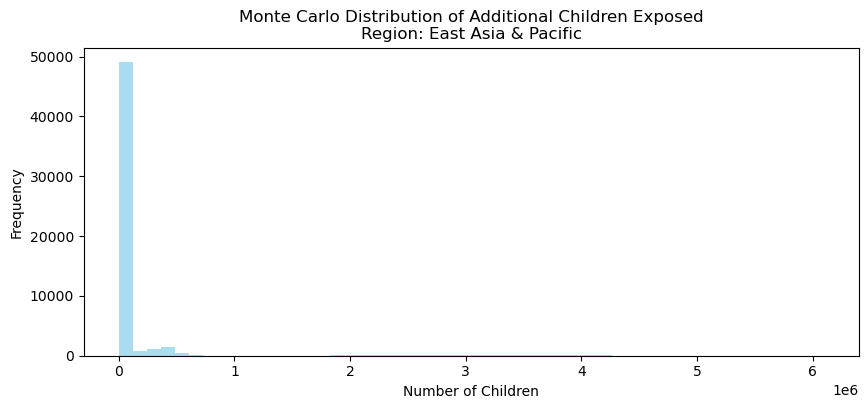

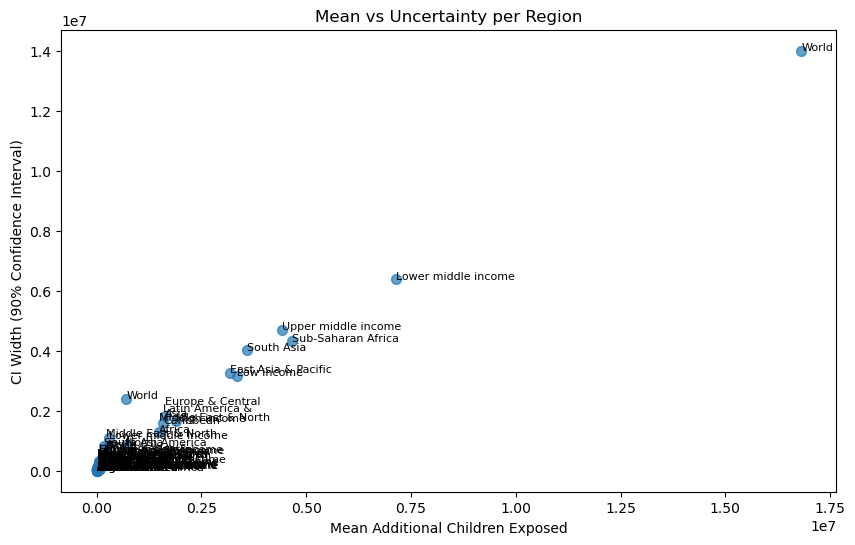

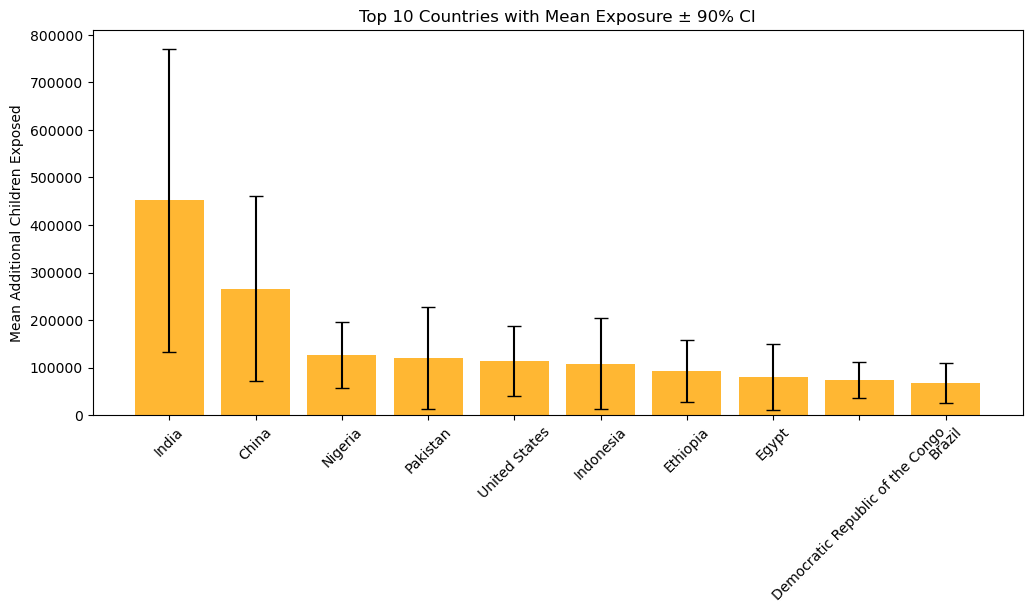

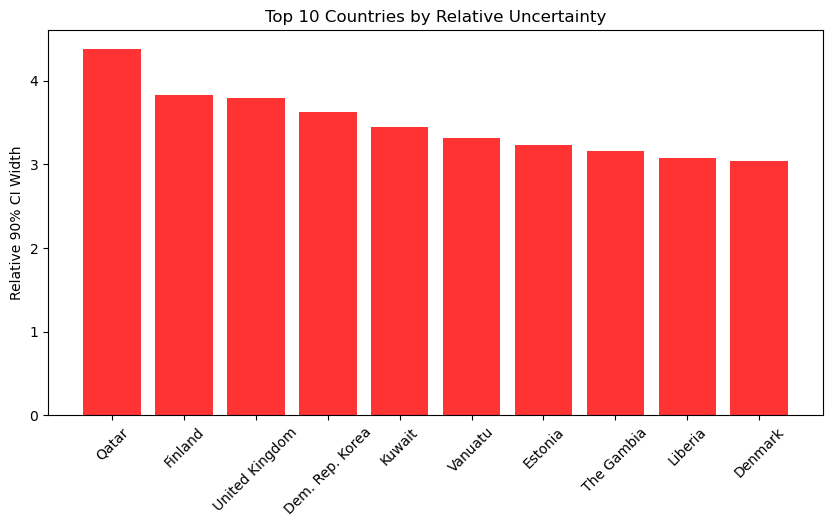

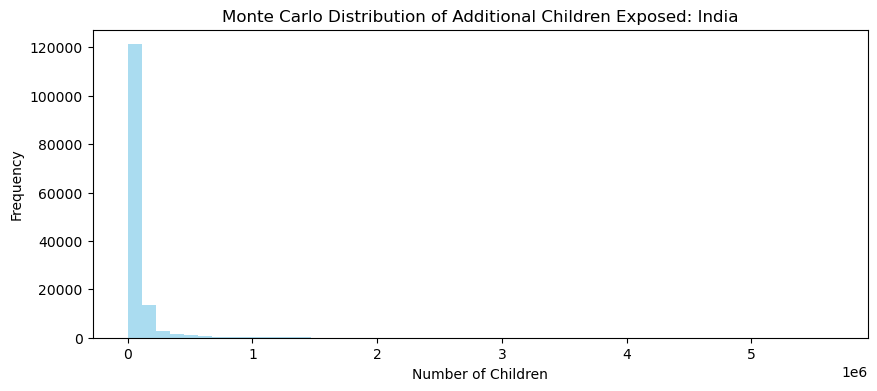

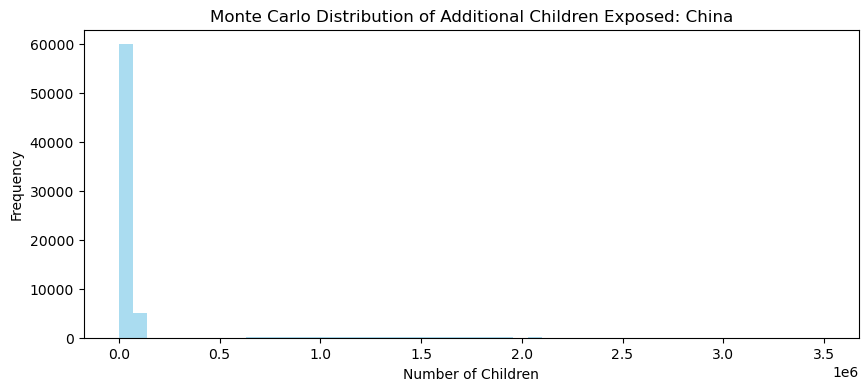

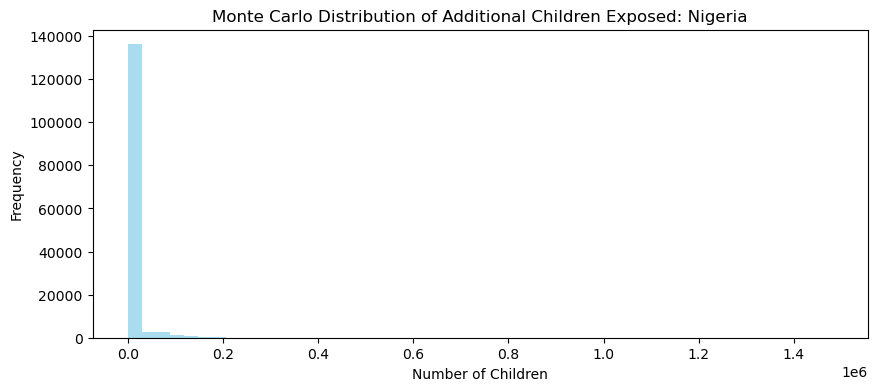

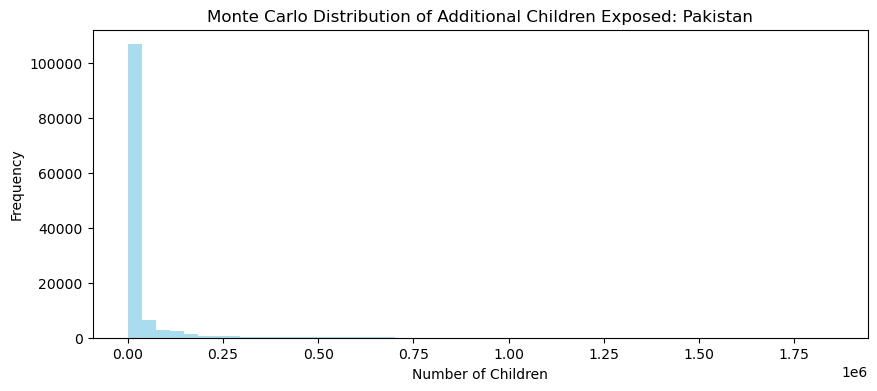

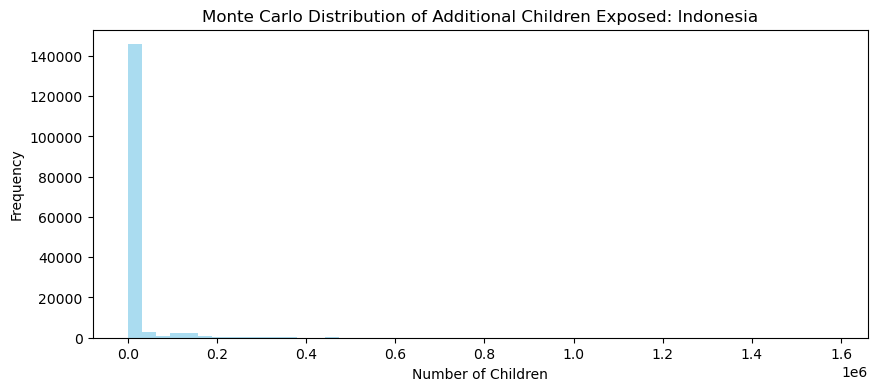

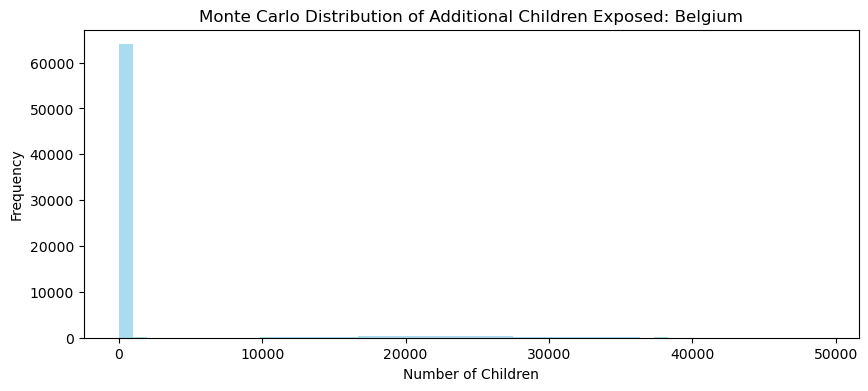

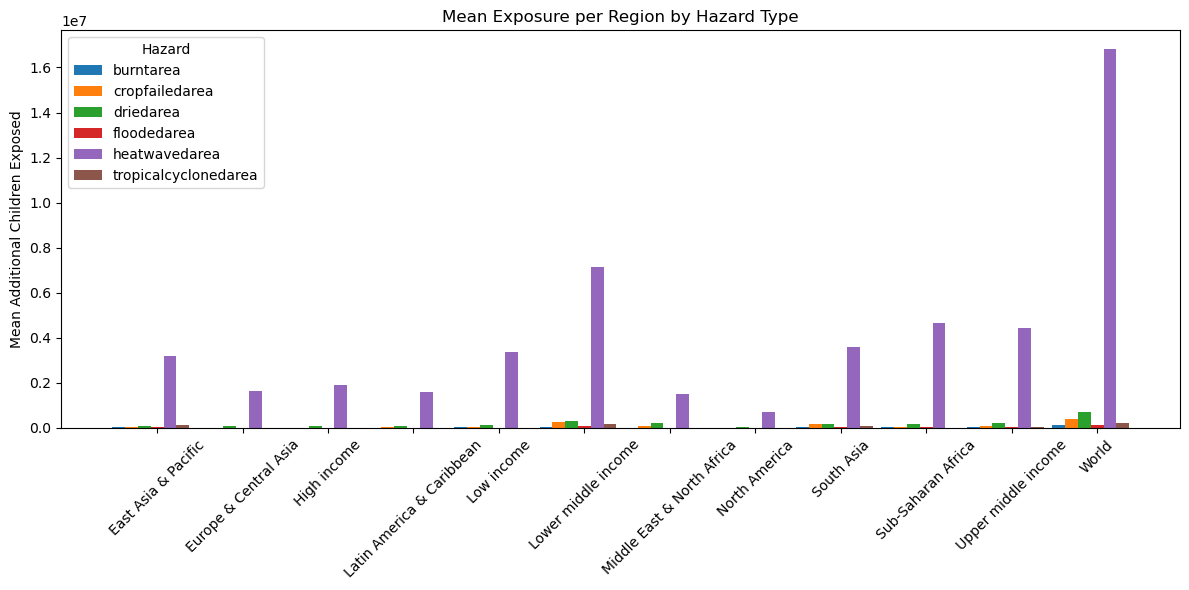

In [71]:
#task11
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from textwrap import wrap

# ============================================
# 1. LOAD DATASETS
# ============================================

with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_regions.pkl", "rb") as f:
    ds_regions = pickle.load(f)

with open("ds_Carbon_Bombs_Permian_Delaware_Tight_all_hazards_all_countries.pkl", "rb") as f:
    ds_countries = pickle.load(f)

# ============================================
# 2. REGION-LEVEL MONTE CARLO DISTRIBUTION
# ============================================

region_name = "East Asia & Pacific"
samples = ds_regions["S2S_LH_results"].sel(region=region_name).values.flatten()

plt.figure(figsize=(10,4))
plt.hist(samples, bins=50, color="skyblue", alpha=0.7)
plt.title(f"Monte Carlo Distribution of Additional Children Exposed\nRegion: {region_name}")
plt.xlabel("Number of Children")
plt.ylabel("Frequency")
plt.show()

# ============================================
# 3. REGION-LEVEL MEAN VS CI WIDTH
# ============================================

df_regions = ds_regions[["mean_val", "ci_lower", "ci_upper"]].to_dataframe().reset_index()
df_regions["ci_width"] = df_regions["ci_upper"] - df_regions["ci_lower"]

plt.figure(figsize=(10,6))
plt.scatter(df_regions["mean_val"], df_regions["ci_width"], s=50, alpha=0.7)
for i, row in df_regions.iterrows():
    if row["mean_val"] > 2:  # annotate high-impact regions
        plt.text(row["mean_val"], row["ci_width"], "\n".join(wrap(row["region"], 20)), fontsize=8)
plt.xlabel("Mean Additional Children Exposed")
plt.ylabel("CI Width (90% Confidence Interval)")
plt.title("Mean vs Uncertainty per Region")
plt.show()

# ============================================
# 4. TOP 10 COUNTRIES BY MEAN EXPOSURE
# ============================================

dims_to_avg = [d for d in ds_countries["mean_val"].dims if d != "country"]
ds_country_stats = ds_countries[["mean_val", "ci_lower", "ci_upper"]].mean(dim=dims_to_avg)
df_countries = ds_country_stats.to_dataframe().reset_index()
df_countries["ci_width"] = df_countries["ci_upper"] - df_countries["ci_lower"]

top10 = df_countries.sort_values("mean_val", ascending=False).head(10)

plt.figure(figsize=(12,5))
plt.bar(top10["country"], top10["mean_val"], yerr=(top10["ci_width"]/2), capsize=5, color="orange", alpha=0.8)
plt.xticks(rotation=45)
plt.ylabel("Mean Additional Children Exposed")
plt.title("Top 10 Countries with Mean Exposure ± 90% CI")
plt.show()

# ============================================
# 5. TOP 10 COUNTRIES BY RELATIVE UNCERTAINTY
# ============================================

df_countries["rel_uncertainty"] = df_countries["ci_width"] / df_countries["mean_val"]
top_rel = df_countries.sort_values("rel_uncertainty", ascending=False).head(10)

plt.figure(figsize=(10,5))
plt.bar(top_rel["country"], top_rel["rel_uncertainty"], color="red", alpha=0.8)
plt.xticks(rotation=45)
plt.ylabel("Relative 90% CI Width")
plt.title("Top 10 Countries by Relative Uncertainty")
plt.show()

# ============================================
# 6. MONTE CARLO HISTOGRAMS FOR SELECTED COUNTRIES
# ============================================

countries_to_plot = ["India", "China", "Nigeria", "Pakistan", "Indonesia", "Belgium"]
for country in countries_to_plot:
    samples = ds_countries["S2S_LH_results"].sel(country=country).values.flatten()
    plt.figure(figsize=(10,4))
    plt.hist(samples, bins=50, color="skyblue", alpha=0.7)
    plt.title(f"Monte Carlo Distribution of Additional Children Exposed: {country}")
    plt.xlabel("Number of Children")
    plt.ylabel("Frequency")
    plt.show()

# ============================================
# 7. HAZARD-SPECIFIC EXPOSURE PER REGION
# ============================================

df_region_hazard = ds_regions["mean_val"].mean(dim="project").to_dataframe().reset_index()
regions = df_region_hazard["region"].unique()
hazards = df_region_hazard["extreme"].unique()

plt.figure(figsize=(12,6))
width = 0.15
x = np.arange(len(regions))

for i, hazard in enumerate(hazards):
    vals = [df_region_hazard[(df_region_hazard.region==r) & (df_region_hazard.extreme==hazard)]["mean_val"].values[0] for r in regions]
    plt.bar(x + i*width, vals, width=width, label=hazard)

plt.xticks(x + width*(len(hazards)/2), regions, rotation=45)
plt.ylabel("Mean Additional Children Exposed")
plt.title("Mean Exposure per Region by Hazard Type")
plt.legend(title="Hazard")
plt.tight_layout()
plt.show()
